### Assessing protein conformational dynamics through the analysis of the publicly available protein structures

The purpose of this notebook is to reproduce the HIV-protease conformational analyses demonstrated in the:

Katebi et al. <i>The Use of Experimental Structures to Model Protein Dynamics</i>, <b>Methods Mol Biol. 2015; 1215: 213–236. </b>

We demonstrate how the complex multi-step procedures can be, to a great extent, simplified with our <b>localpdb</b> package and other commonly used bioinformatics tools.

#### Imports

In [2]:
import gzip
from localpdb import PDB

from Bio.PDB import Select
from Bio.PDB.PDBParser import PDBParser
from Bio.PDB import PDBIO
from Bio import pairwise2
from Bio.SubsMat import MatrixInfo as matlist


import pytraj as pt
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

from sklearn.cluster import KMeans

#### Initiate localpdb and load clustering data

In [5]:
lpdb = PDB('/ssd/db/localpdb', plugins=['PDBSeqresMapper', 'PDBClustering'])

In [6]:
lpdb.load_clustering_data(redundancy=90)

#### Select clusters containing HIV-protease entries
Note that you can use lpdb.search_seq() method or other selectors

In [7]:
lpdb.chains = lpdb.chains[lpdb.chains['clust-90'] == '3']

#### Select entries of reasonable quality

In [8]:
lpdb.entries = lpdb.entries.query('method == "diffraction"')
lpdb.entries = lpdb.entries.query('resolution <= 3')

#### Find only entries that have both A and B chains
(We want to analyze dimers only)

In [9]:
clean_idx = [chain for idx in lpdb.entries.index 
             if f'{idx}_A' and f'{idx}_B' in lpdb.chains.index 
             for chain in [f'{idx}_A', f'{idx}_B']]
lpdb.chains = lpdb.chains.loc[clean_idx]

#### Auxiliary definitions to process PDB structures

In [53]:
parser = PDBParser(QUIET=True)
writer = PDBIO()

def is_continous(list_):
    try:
        return all([int(list_[i]) == int(list_[i + 1]) - 1 for i in range(0, len(list_) - 1)])
    except ValueError:
        return False

class CustomSelect(Select):
    def __init__(self, accept_dict):
        self.accept_dict = accept_dict
        
    def accept_residue(self, residue):
        try:
            return residue.get_id()[1] in self.accept_dict[residue.get_parent().id]
        except KeyError:
            return False

    def accept_atom(self, atom):
        if (not atom.is_disordered()) or atom.get_altloc() == 'A' or atom.get_altloc() == '1':
            atom.set_altloc(' ')
            if atom.get_name() == 'CA':
                return True
        return False

#### Process PDB structures
Here the PDB sequences are aligned to the query reference sequence of the HIV protease. Subsequently chains A and B are extracted. Structures are checked for missing gaps that would prevent subsequent PCA analyses.

In [12]:
qseq = 'PQVTLWQRPLVTIKIGGQLKEALLDTGADDTVLEEMSLPGRWKPKMIGGIGGFIKVRQYDQILIEICGHKAIGTVLVGPTPVNIIGRNLLTQIGATLNF'
fns = []
for idx in lpdb.entries.index:
    indices = {}
    for chain in ['A', 'B']:
        sseq = lpdb.chains.loc[f'{idx}_{chain}', 'sequence']
        mapping = lpdb.get_pdbseqres_mapping(f'{idx}_{chain}', reverse=True)
        aln = pairwise2.align.globaldd(qseq, sseq, matlist.blosum62, -11, -1, -11, -1)
        qaln, saln = aln[0][0], aln[0][1]
        qidx, sidx = qaln.index(qseq), saln.index(sseq)
        assert qseq in qaln
        assert sseq in saln
        try:
            indices[chain] = [k for k in range(int(mapping[qidx]), int(mapping[qidx+len(qseq)-1]))] if is_continous(list(mapping.keys())) else None
        except KeyError:
            indices[chain] = None
    if indices['A'] and indices['B']:
        with gzip.open(lpdb.entries.loc[idx, 'pdb_fn'], 'rt') as f:
            s = parser.get_structure('s', f)[0]
        writer.set_structure(s)
        writer.save(f'hiv_protease/{idx}.pdb', select=CustomSelect(indices))
        fns.append(f'hiv_protease/{idx}.pdb')

#### Load processed structures and perform PCA

In [20]:
traj = pt.load(fns, top=fns[0])
pca = pt.pca(traj, '@CA', n_vecs=-1, fit=True)

#### Cluster PCA representations

In [14]:
km = KMeans(n_clusters=3)
km.fit(pca[0].T)

KMeans(n_clusters=3)

#### Prepare labels and plot

In [15]:
# Find and store centroid structures
label_idxs = {}
for i, center in enumerate(km.cluster_centers_):
    centroid = [100]
    for j, point in enumerate(pca[0].T):
        id_ = fns[j].split('/')[1][0:4]
        dist = np.linalg.norm(point-center)
        if dist < centroid[0]:
            centroid = (dist, point[0], point[1], id_)
            label_idxs[i] = centroid

Text(0, 0.5, 'PC2 ($\\AA$)')

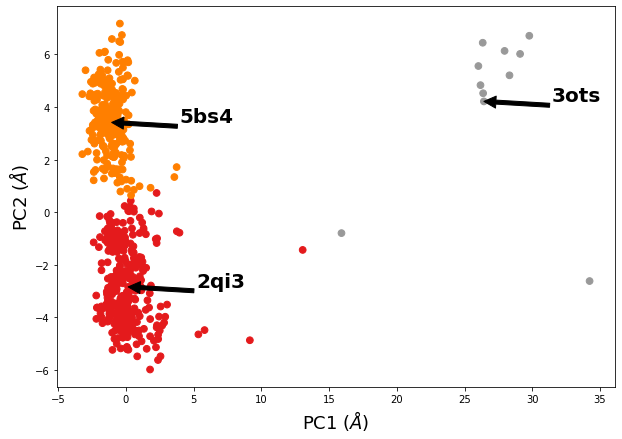

In [18]:
# Plot
fig, ax = plt.subplots(figsize=(10, 7))
ax.scatter(pca[0][0], pca[0][1], s=45, c=km.labels_, cmap='Set1')
for _, x, y, label in label_idxs.values(): 
    ax.annotate(label, (x, y), xytext=(x+5, y), fontsize=20, fontweight='bold',
                arrowprops=dict(facecolor='black'))
plt.xlabel(r'PC1 ($\AA$)', fontsize=18)
plt.ylabel(r'PC2 ($\AA$)', fontsize=18)

The obtained representation nicely corresponds to the one obtained in the original paper - <a href="https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4206088/figure/F3/?report=objectonly">compare with the reference</a>

#### Variance explained by subsequent PCs

In [40]:
cum_var = (100*np.cumsum(pca[1][0])/np.sum(pca[1][0]))[0:9]

Text(0, 0.5, 'Cumulated variance (%)')

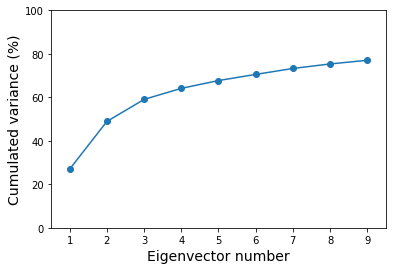

In [52]:
plt.plot(np.arange(1, len(cum_var)+1, 1), cum_var)
plt.scatter(np.arange(1, len(cum_var)+1, 1), cum_var)
plt.ylim(0, 100)
plt.xlim(0.5, 9.5)
plt.xlabel(r'Eigenvector number', fontsize=14)
plt.ylabel(r'Cumulated variance (%)', fontsize=14)